In [1]:
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn import input_data, signal, datasets, image, plotting
from nilearn.regions import connected_label_regions
from templateflow import api
from bct import distance_wei, modularity_louvain_und

import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.multitest import multipletests
import os

In [2]:
def get_folders(path):
    """Gets all folders within a specified path."""
    folders = []
    for entry in os.scandir(path):
        if entry.is_dir():
            folders.append(entry.name)
    return folders

In [3]:
def load_and_prepare_data(bold_files, confounds_files, difumo_atlas):
    """
    Load and prepare BOLD data using the DiFuMo probabilistic atlas

    Parameters:
    -----------
    bold_files : list of str
        Paths to preprocessed BOLD data for each subject/session
    confounds_files : list of str
        Paths to confound regressors from fMRIprep
    difumo_atlas : str or NiftiImage
        Path to DiFuMo probabilistic atlas or loaded atlas image
    target_roi_indices : list of int
        Indices of ROIs in target region (subgenual ACC)

    Returns:
    --------
    time_series_dict : dict
        Dictionary containing cleaned time series for each subject/condition
    """
    # Use NiftiMapsMasker instead of NiftiLabelsMasker for probabilistic atlas
    masker = input_data.NiftiMapsMasker(
        maps_img=difumo_atlas,
        standardize=True,
        detrend=True,
        low_pass=0.15,
        high_pass=0.01,
        t_r=1.0,
        memory='nilearn_cache',  # Cache computations
        memory_level=1,
        verbose=1
    )

    time_series_dict = {
        'active': [],
        'sham': []
    }

    for bold_file, confound_file in zip(bold_files, confounds_files):
        # Load confounds
        confounds = pd.read_csv(confound_file, sep='\t')

        # Select specific confound regressors
        selected_confounds = pd.concat([
            # Motion parameters and their derivatives/quadratic terms
            confounds.filter(regex='^(trans|rot)_(x|y|z)($|_derivative1$|_power2$)'),

            # CompCor components
            #confounds.filter(regex='^[at]_comp_cor_\d+'),

            # Global signals
            #confounds[['csf', 'white_matter', 'global_signal']],

            # Motion outliers
            #confounds.filter(regex='^motion_outlier'),

            # Edge/crown signals
            #confounds.filter(regex='^edge_')
        ], axis=1)

        # remove any columns in selected_confounds that have nans
        selected_confounds = selected_confounds.dropna(axis=1)

        # Extract time series with confound regression
        # This will now return time series for each probabilistic component
        time_series = masker.fit_transform(bold_file, confounds=selected_confounds)

        # Sort into conditions
        if 'ACTIVE' in bold_file:
            time_series_dict['active'].append(time_series)
        else:
            time_series_dict['sham'].append(time_series)

    return time_series_dict

In [4]:
def load_difumo_atlas(atlas_path):
    """
    Load DiFuMo atlas and verify its dimensions

    Parameters:
    -----------
    atlas_path : str
        Path to the DiFuMo atlas file

    Returns:
    --------
    atlas_img : Nifti1Image
        Loaded atlas image
    """
    from nilearn import image

    atlas_img = image.load_img(atlas_path)

    # Verify this is a 4D image with 1024 components
    if atlas_img.ndim != 4:
        raise ValueError("Expected 4D atlas image")
    if atlas_img.shape[-1] != 1024:
        raise ValueError(f"Expected 1024 components, got {atlas_img.shape[-1]}")

    return atlas_img

In [5]:
def analyze_immediate_effects(time_series_dict, stim_onsets, target_roi_indices):
    """
    Analyze immediate effects of stimulation using event-related averaging

    Parameters:
    -----------
    time_series_dict : dict
        Dictionary containing time series data
    stim_onsets : array-like
        Stimulus onset times in TRs
    target_roi_indices : list of int
        Indices of target ROIs

    Returns:
    --------
    results_dict : dict
        Dictionary containing statistical results
    """
    results_dict = {}

    # Define time window for analysis (e.g., -5 to +15 TRs around stim)
    pre_stim = 5
    post_stim = 40

    all_responses = {'active': [], 'sham': []}

    for condition in ['active', 'sham']:
        for subj_data in time_series_dict[condition]:
            # Extract epochs around each stimulus
            epochs = []
            for onset in stim_onsets:
                epoch = subj_data[onset-pre_stim:onset+post_stim, :]
                if epoch.shape[0] == (pre_stim + post_stim):
                    epochs.append(epoch)

            # Average across epochs for this subject
            subj_response = np.mean(epochs, axis=0)
            all_responses[condition].append(subj_response)

            #all_responses.append(subj_response)

        # Convert to array
        all_responses[condition] = np.array(all_responses[condition])

    return all_responses

In [6]:
## Generate a list of all available bold records from both ACTIVE and SHAM sessions
data_root = '/Users/jacekdmochowski/PROJECTS/fus/data/resampled_bold_flywheel/'
# list all folders in data_root
folders = [f for f in os.listdir(data_root) if os.path.isdir(os.path.join(data_root, f))]
bold_files = []
confounds_files = []
for folder in folders:
    # find file in output_folder that contains 'preproc_bold_resampled'
    output_folder = os.listdir(os.path.join(os.path.join(data_root,folder),'output'))
    for file in output_folder:
        if 'preproc_bold_resampled' in file:
            bold_files.append(os.path.join(os.path.join(data_root,folder),'output',file))

    # confounds timeseries
    input_folder=os.path.join(os.path.join(data_root,folder),'input')
    tmp=get_folders(os.path.join(os.path.join(data_root,folder),'input'))[0]
    tmp2=[x for x in get_folders(os.path.join(input_folder,tmp)) if 'sub-' in x]
    tmp3=os.path.join(os.path.join(input_folder,tmp),tmp2[0])
    tmp4=[os.path.join(tmp3,x) for x in os.listdir(tmp3) if 'ses-' in x][0]
    tmp5=[os.path.join(tmp4,x) for x in os.listdir(tmp4) if 'func' in x][0]
    confounds_files.append([os.path.join(tmp5,x) for x in os.listdir(tmp5) if 'confounds_timeseries.tsv' in x][0])

print(f"Found {len(bold_files)} bold files")
print(f"Found {len(confounds_files)} confounds files")

Found 32 bold files
Found 32 confounds files


In [7]:
path_to_difumo = '/Users/jacekdmochowski/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-02_atlas-DiFuMo_desc-1024dimensions_probseg.nii.gz'
try:
    difumo_atlas = load_difumo_atlas(path_to_difumo)
except ValueError as e:
    print(f"Error loading DiFuMo atlas: {e}")
    print("Attempting to download from TemplateFlow")
    if path_to_difumo is None:
        path_to_difumo = api.get('MNI152NLin2009cAsym', atlas="DiFuMo", desc="1024dimensions", resolution=2, suffix="probseg", extension="nii.gz")
    difumo_atlas = nib.load(path_to_difumo)

In [8]:
time_series = load_and_prepare_data(bold_files, confounds_files, difumo_atlas)

[NiftiMapsMasker.wrapped] loading regions from None
[NiftiMapsMasker.wrapped] loading regions from None
[NiftiMapsMasker.wrapped] loading regions from None
[NiftiMapsMasker.wrapped] loading regions from None
[NiftiMapsMasker.wrapped] loading regions from None
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/Users/jacekdmochowski/PROJECTS/fus/data/resampled_bold_flywheel/resampled_bold_sub-COACHE_ses-ACTIVE--2024-09-13/output/sub-COACHE_ses-ACTIVE_task-prefuspost_space-Schaefer2018_desc-preproc_bold_resampled.nii.gz', 
<nilearn.maskers.nifti_maps_masker._ExtractionFunctor object at 0x3096654b0>, { 'allow_overlap': True,
  'clean_kwargs': {},
  'detrend': True,
  'dtype': None,
  'high_pass': 0.01,
  'high_variance_confounds': False,
  'keep_masked_maps': True,
  'low_pass': 0.15,
  'maps_img': <nibabel.nifti1.Nifti1Image object at 0x103d5b4c0>,
  'mask_img': None,
  

In [15]:
# save time_series dictionary to disk
import pickle
with open('../data/precomputed/difumo_time_series.pkl', 'wb') as f:
    pickle.dump(time_series, f)

In [9]:
stim_onsets = np.array([0,60,120,180,240])+300
all_responses = analyze_immediate_effects(time_series, stim_onsets, [])

In [10]:
len(all_responses['active']), len(all_responses['sham'])

(16, 16)

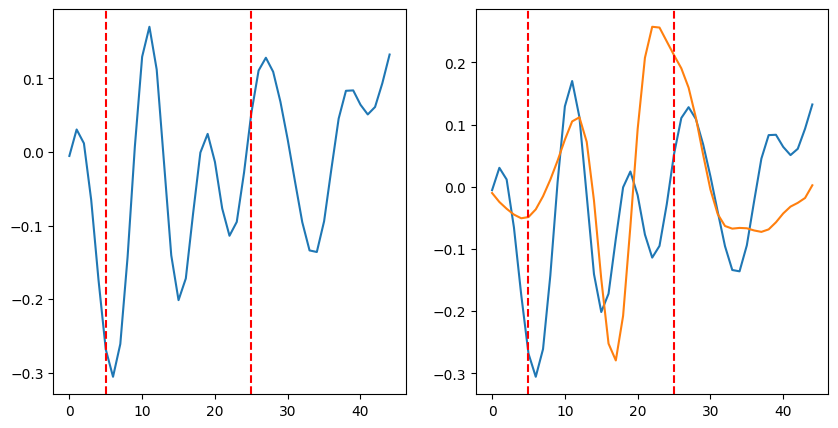

In [13]:

x3_active = np.zeros((len(all_responses['active']),all_responses['active'][0].shape[0],all_responses['active'][0].shape[1]))
x3_sham = np.zeros((len(all_responses['sham']),all_responses['sham'][0].shape[0],all_responses['sham'][0].shape[1]))

for i, x in enumerate(all_responses['active']):
    x3_active[i,:,:] = x

for i, x in enumerate(all_responses['sham']):
    x3_sham[i,:,:] = x

mu_active = np.mean(x3_active, axis=0)
mu_sham = np.mean(x3_sham, axis=0)

roi=133

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(mu_sham[:, roi], label='sham')
ax[0].axvline(5, color='r', linestyle='--')
ax[0].axvline(25, color='r', linestyle='--')

ax[1].plot(mu_sham[:, roi], label='sham')
ax[1].plot(mu_active[:, roi], label='active')
ax[1].axvline(5, color='r', linestyle='--')
ax[1].axvline(25, color='r', linestyle='--')

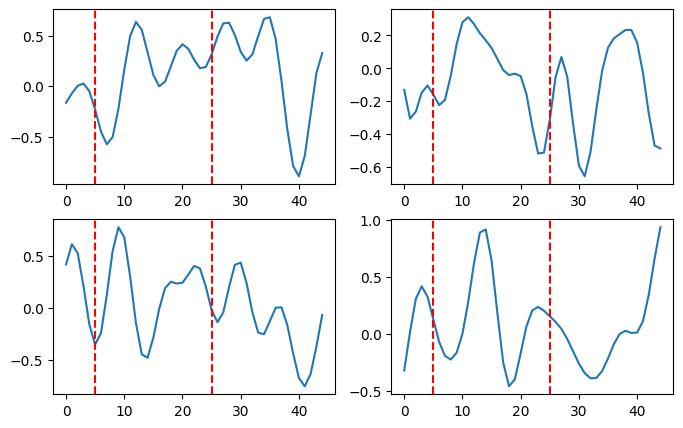

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(8, 5))
subj = 0
ax[0,0].plot(all_responses['sham'][0][:, 133], label='sham')
ax[0,0].axvline(5, color='r', linestyle='--')
ax[0,0].axvline(25, color='r', linestyle='--')

ax[1,0].plot(all_responses['sham'][1][:, 133], label='active')
ax[1,0].axvline(5, color='r', linestyle='--')
ax[1,0].axvline(25, color='r', linestyle='--')

ax[0,1].plot(all_responses['active'][0][:, 133], label='sham')
ax[0,1].axvline(5, color='r', linestyle='--')
ax[0,1].axvline(25, color='r', linestyle='--')

ax[1,1].plot(all_responses['active'][1][:, 133], label='active')
ax[1,1].axvline(5, color='r', linestyle='--')
ax[1,1].axvline(25, color='r', linestyle='--')


In [23]:
# Fetch DiFuMo labels
difumo = datasets.fetch_atlas_difumo(dimension=1024)
labels = difumo.labels  # List of 1024 anatomical labels
labels[132]
#sgacc_inds = [i for i in range(len(labels)) if 'subgenual' in labels[i][1].lower()]

(133, 'Occipitotemporal sulcus mid-anterior RH', 'DorsAttnB', 'DorsAttnA', 0.65167083, 0.32183573, 0.02647071)

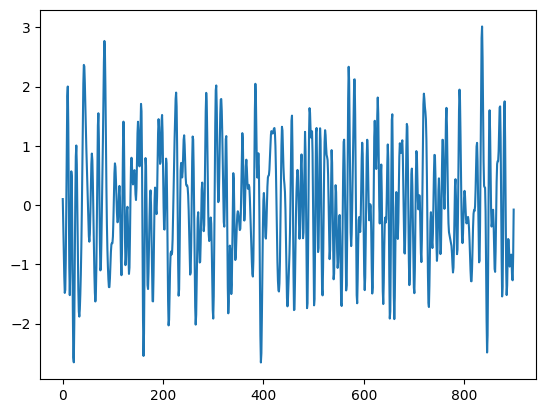

In [15]:
time_series['active'][0].shape

plt.plot(time_series['sham'][1][:, 133])

## Scrapheap

In [5]:
def create_sgacc_mask_from_harvard_oxford():
    """
    Create sgACC mask using Harvard-Oxford Atlas
    """
    # Download Harvard-Oxford Atlas
    ho_atlas = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
    atlas_img = image.load_img(ho_atlas.maps)
    atlas_data = atlas_img.get_fdata()

    # ACC label is 25 in Harvard-Oxford
    acc_mask = atlas_data == 25

    # Extract subgenual portion (roughly y > 26, z < 0 in MNI)
    affine = atlas_img.affine
    coords = np.where(acc_mask)
    mni_coords = image.coord_transform(
        coords[0], coords[1], coords[2],
        affine
    )

    sgacc_mask = np.zeros_like(atlas_data)
    for x, y, z, orig_x, orig_y, orig_z in zip(
        mni_coords[0], mni_coords[1], mni_coords[2],
        coords[0], coords[1], coords[2]
    ):
        if y > 26 and z < 0:
            sgacc_mask[orig_x, orig_y, orig_z] = 1

    return image.new_img_like(atlas_img, sgacc_mask)

In [6]:
def create_sgacc_mask_from_coordinates():
    """
    Create sgACC mask using canonical coordinates
    """
    # Create empty 2mm MNI template
    template = datasets.load_mni152_template()

    # Canonical coordinates for sgACC (from literature)
    coords = [(0, 26, -5)]  # Center coordinate

    # Create spherical ROI
    radius = 8  # mm
    sphere = plotting.coords_to_roi(
        coords, radius,
        template,
        neighbor_distance='euclidean'
    )

    return sphere

In [7]:
def resample_mask_to_bold(mask_img, bold_reference):
    """
    Resample mask to match BOLD data space

    Parameters:
    -----------
    mask_img : Nifti1Image
        sgACC mask
    bold_reference : str or Nifti1Image
        Reference BOLD image or path

    Returns:
    --------
    resampled_mask : Nifti1Image
        Resampled mask matching BOLD space
    """
    from nilearn import image

    # Load reference if path provided
    if isinstance(bold_reference, str):
        bold_reference = image.load_img(bold_reference)

    # Resample mask to match BOLD
    resampled_mask = image.resample_to_img(
        mask_img,
        bold_reference,
        interpolation='nearest'  # Use nearest neighbor for binary masks
    )

    # Ensure binary
    mask_data = resampled_mask.get_fdata()
    mask_data = (mask_data > 0.5).astype(float)

    return image.new_img_like(resampled_mask, mask_data)

In [8]:
def identify_sgacc_components(difumo_atlas, sgacc_mask):
    """
    Find DiFuMo components overlapping with sgACC.

    Parameters:
    -----------
    difumo_atlas : Nifti1Image
        4D DiFuMo atlas (1024 probability maps)
    sgacc_mask : Nifti1Image
        Binary mask of sgACC region

    Returns:
    --------
    component_weights : array
        Overlap scores for each component
    """
    # Resample mask to atlas space if needed
    sgacc_mask = image.resample_to_img(sgacc_mask, difumo_atlas, interpolation='nearest')

    # Calculate overlap for each component
    mask_data = sgacc_mask.get_fdata()
    atlas_data = difumo_atlas.get_fdata()

    overlaps = []
    for i in range(atlas_data.shape[-1]):
        component = atlas_data[..., i]
        overlap = np.sum(component * mask_data) / np.sum(mask_data)
        overlaps.append(overlap)

    return np.array(overlaps)

In [31]:
def analyze_immediate_effects(time_series_dict, stim_onsets, target_roi_indices):
    """
    Analyze immediate effects of stimulation using event-related averaging

    Parameters:
    -----------
    time_series_dict : dict
        Dictionary containing time series data
    stim_onsets : array-like
        Stimulus onset times in TRs
    target_roi_indices : list of int
        Indices of target ROIs

    Returns:
    --------
    results_dict : dict
        Dictionary containing statistical results
    """
    results_dict = {}

    # Define time window for analysis (e.g., -5 to +15 TRs around stim)
    pre_stim = 5
    post_stim = 40

    all_responses = []
    for condition in ['active', 'sham']:
        #all_responses = []

        for subj_data in time_series_dict[condition]:
            # Extract epochs around each stimulus
            epochs = []
            for onset in stim_onsets:
                epoch = subj_data[onset-pre_stim:onset+post_stim, :]
                if epoch.shape[0] == (pre_stim + post_stim):
                    epochs.append(epoch)

            # Average across epochs for this subject
            subj_response = np.mean(epochs, axis=0)
            all_responses.append(subj_response)

        # Convert to array
        all_responses = np.array(all_responses)

    return all_responses

"""
        baseline = np.mean(all_responses[:, :pre_stim, :], axis=1)
        for t in range(all_responses.shape[1]):
            _, p_vals = stats.ttest_rel(
                all_responses[:, t, :],
                baseline,
                axis=0
            )
            # FDR correction
            _, p_vals_fdr = multipletests(p_vals, method='fdr_bh')[:2]

            results_dict[f'{condition}_timepoint_{t}'] = {
                'p_vals': p_vals,
                'p_vals_fdr': p_vals_fdr
            }

    return results_dict
"""

"\n        baseline = np.mean(all_responses[:, :pre_stim, :], axis=1)\n        for t in range(all_responses.shape[1]):\n            _, p_vals = stats.ttest_rel(\n                all_responses[:, t, :],\n                baseline,\n                axis=0\n            )\n            # FDR correction\n            _, p_vals_fdr = multipletests(p_vals, method='fdr_bh')[:2]\n\n            results_dict[f'{condition}_timepoint_{t}'] = {\n                'p_vals': p_vals,\n                'p_vals_fdr': p_vals_fdr\n            }\n\n    return results_dict\n"

In [ ]:
def analyze_functional_connectivity(time_series_dict, window_size=50):
    """
    Analyze dynamic functional connectivity using sliding windows

    Parameters:
    -----------
    time_series_dict : dict
        Dictionary containing time series data
    window_size : int
        Size of sliding window in TRs

    Returns:
    --------
    fc_results : dict
        Dictionary containing FC analysis results
    """
    fc_results = {}

    for condition in ['active', 'sham']:
        all_fc_matrices = []

        for subj_data in time_series_dict[condition]:
            # Compute dynamic FC using sliding windows
            n_windows = subj_data.shape[0] - window_size + 1
            fc_matrices = []

            for i in range(n_windows):
                window_data = subj_data[i:i+window_size, :]
                fc_matrix = connectivity.ConnectivityMeasure(
                    kind='correlation'
                ).fit_transform([window_data])[0]
                fc_matrices.append(fc_matrix)

            all_fc_matrices.append(fc_matrices)

        fc_results[condition] = np.array(all_fc_matrices)

    # Compute statistics comparing conditions
    _, p_vals = stats.ttest_rel(
        fc_results['active'].mean(axis=1),
        fc_results['sham'].mean(axis=1),
        axis=0
    )

    # FDR correction
    _, p_vals_fdr = multipletests(p_vals.flatten(), method='fdr_bh')[:2]

    fc_results['statistics'] = {
        'p_vals': p_vals,
        'p_vals_fdr': p_vals_fdr.reshape(p_vals.shape)
    }

    return fc_results


In [ ]:
def analyze_delayed_effects(time_series_dict, target_roi_indices):
    """
    Analyze delayed effects using change point detection

    Parameters:
    -----------
    time_series_dict : dict
        Dictionary containing time series data
    target_roi_indices : list of int
        Indices of target ROIs

    Returns:
    --------
    changepoint_results : dict
        Dictionary containing changepoint analysis results
    """
    from ruptures import Binseg  # You'll need to install ruptures package

    changepoint_results = {}

    for condition in ['active', 'sham']:
        subject_changes = []

        for subj_data in time_series_dict[condition]:
            # Focus on target ROIs
            target_data = subj_data[:, target_roi_indices]

            # Detect change points
            model = Binseg(model="l2").fit(target_data)
            changes = model.predict(n_bkps=3)  # Detect up to 3 change points

            subject_changes.append(changes)

        changepoint_results[condition] = subject_changes

    return changepoint_results


In [ ]:
def run_complete_analysis(bold_files, confounds_files, atlas_labels, target_roi_indices):
    """
    Run complete analysis pipeline
    """
    # Load and prepare data
    time_series_dict = load_and_prepare_data(
        bold_files, confounds_files, atlas_labels, target_roi_indices
    )

    # Define stimulus onsets (adjust based on your paradigm)
    stim_onsets = np.arange(150, 300, 30)  # Example for 5-min baseline, then stim every 30 TRs

    # Run analyses
    immediate_effects = analyze_immediate_effects(
        time_series_dict, stim_onsets, target_roi_indices
    )

    fc_results = analyze_functional_connectivity(
        time_series_dict
    )

    delayed_effects = analyze_delayed_effects(
        time_series_dict, target_roi_indices
    )

    return {
        'immediate_effects': immediate_effects,
        'fc_results': fc_results,
        'delayed_effects': delayed_effects
    }

In [9]:
def analyze_component_modulation(time_series_dict, stim_onsets, component_idx):
    """
    Analyze stimulation effects on specific components.

    Parameters:
    -----------
    time_series_dict : dict
        Output from load_and_prepare_data()
    stim_onsets : array
        Stimulation onset times in TRs
    component_idx : array
        Indices of components to analyze

    Returns:
    --------
    stats_dict : dict
        Statistical results
    """
    pre_window = 5  # TRs before stim
    post_window = 15  # TRs after stim

    results = {}
    for condition in ['active', 'sham']:
        # Extract epochs around stimulation
        epochs = []
        for subj_data in time_series_dict[condition]:
            subj_epochs = []
            for onset in stim_onsets:
                epoch = subj_data[onset-pre_window:onset+post_window, component_idx]
                if epoch.shape[0] == (pre_window + post_window):
                    subj_epochs.append(epoch)
            epochs.append(np.mean(subj_epochs, axis=0))  # Average across epochs
        epochs = np.array(epochs)  # [subjects, time, components]

        # Compare post-stim to baseline
        baseline = np.mean(epochs[:, :pre_window, :], axis=1)  # [subjects, components]
        t_stats = []
        p_vals = []
        for t in range(epochs.shape[1]):
            t_stat, p_val = stats.ttest_rel(epochs[:, t, :], baseline, axis=0)
            t_stats.append(t_stat)
            p_vals.append(p_val)

        results[condition] = {
            'epochs': epochs,
            't_stats': np.array(t_stats),
            'p_vals': np.array(p_vals)
        }

    return results

# Example usage:
"""
# Find relevant components
sgacc_mask = image.load_img('sgacc_mask.nii.gz')
overlaps = identify_sgacc_components(difumo_atlas, sgacc_mask)
relevant_components = np.where(overlaps > 0.1)[0]

# Analyze modulation
stim_onsets = np.arange(150, 300, 30)  # Example timing
results = analyze_component_modulation(time_series_dict, stim_onsets, relevant_components)
"""

"\n# Find relevant components\nsgacc_mask = image.load_img('sgacc_mask.nii.gz')\noverlaps = identify_sgacc_components(difumo_atlas, sgacc_mask)\nrelevant_components = np.where(overlaps > 0.1)[0]\n\n# Analyze modulation\nstim_onsets = np.arange(150, 300, 30)  # Example timing\nresults = analyze_component_modulation(time_series_dict, stim_onsets, relevant_components)\n"

In [ ]:
#plotting.plot_roi(resampled_mask, title='sgACC mask')

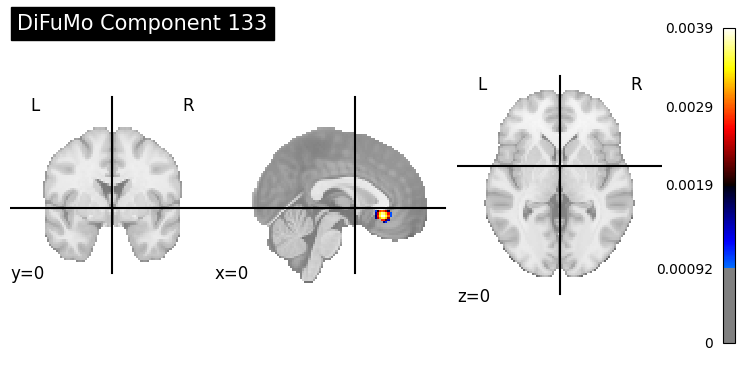

In [96]:
component_idx=133
component_img = image.index_img(difumo_atlas, component_idx)
#component_img.shape

threshold_percentile=10
# Threshold the map to show only highest weights
data = component_img.get_fdata()
threshold = np.percentile(data[data > 0], threshold_percentile)

# Create plot
display = plotting.plot_stat_map(
        component_img,
        threshold=threshold,
        title=f'DiFuMo Component {component_idx}',
        cut_coords=(0, 0, 0),  # Start at origin
        display_mode='ortho',
        colorbar=True
)

In [72]:
# Find relevant components
#sgacc_mask = image.load_img('sgacc_mask.nii.gz')
#overlaps = identify_sgacc_components(atlas_img, resampled_mask)
#relevant_components = np.where(overlaps > 0.01)[0]

In [32]:
stim_onsets = np.array([0,60,120,180,240])+300
all_responses = analyze_immediate_effects(time_series, stim_onsets, [1])

In [33]:
all_responses.shape

(1, 45, 1024)

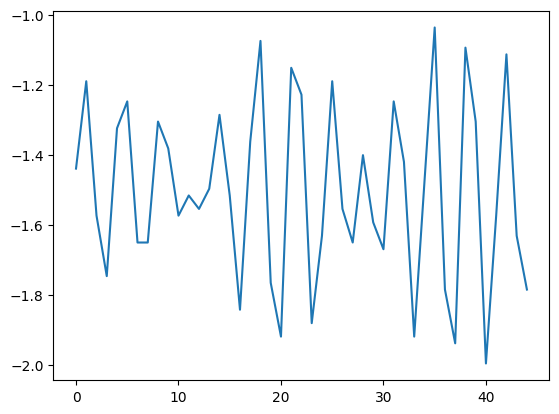

In [36]:
import matplotlib.pyplot as plt
plt.plot(all_responses[0][:, 500])

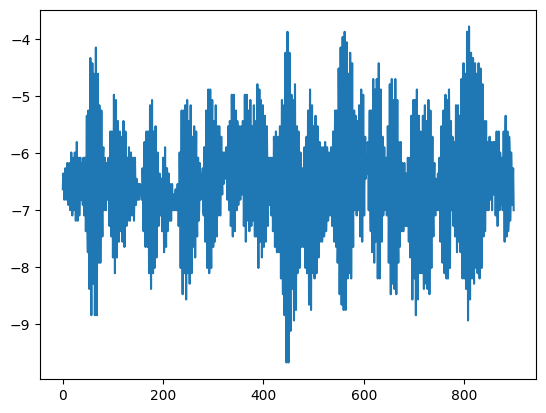

In [24]:
# plot some ROIs
import matplotlib.pyplot as plt
plt.plot(time_series['active'][0][:, 133])